In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import json
import os
from read_O3_LVK_results import *
import sys
sys.path.append('./../code/')
from utilities import massModel
from scipy.special import erf

In [27]:
saved = np.array([])
while saved.size<100000:
    
    new = 6.*np.random.random()-3.
    p_new = np.exp(-(new/1.72)**4)
    if np.random.random()<p_new:
        saved = np.append(saved,new)

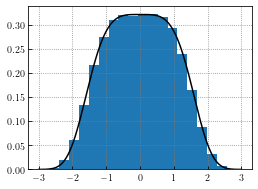

In [28]:
from scipy.special import gamma

fig,ax = plt.subplots()
ax.hist(saved,bins=20,density=True)

xs = np.linspace(-3,3,1000)
ys = np.exp(-(xs/1.72)**4)/(2.*gamma(5./4.)*1.72)
ax.plot(xs,ys,color='black')

plt.show()

In [29]:
np.std(saved)

0.9982817709467761

In [31]:
np.sqrt(4.*gamma(5./4.)/gamma(3./4.))**4

8.753758460905908

In [33]:
np.log(100.),np.log(5.)

(4.605170185988092, 1.6094379124341003)

In [2]:
precomputed_data = "stored_chi_cost_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    chis = traces['chis']
    costs = traces['costs']
    f_chis = traces['f_chis']
    f_costs = traces['f_costs']
    R_ref = traces['R_ref']
    f_a01 = traces['f_a01']
    f_cost1 = traces['f_cost1']
    bq = traces['bq']
    alpha = traces['alpha']
    mu_m1 = traces['mu_m1']
    sig_m1 = traces['sig_m1']
    log_f_peak = traces['log_f_peak']
    mMin = traces['mMin']
    mMax = traces['mMax']
    log_dmMin = traces['log_dmMin']
    log_dmMax = traces['log_dmMax']
    kappa = traces['kappa']
    
else:

    # Load inference data
    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_chi_cost_1000_1500_noReweighting.cdf")

    # Also extract mass and mass ratio values
    chi_cost_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_chi_cost_data_1000_1500_noReweighting.npy',allow_pickle=True)[()]
    chi_values = chi_cost_data['chi_allSamples']
    cost_values = chi_cost_data['cost_allSamples']
    
    alpha_values = np.concatenate([
        inference_data.posterior.alpha.values[i,:]
        for i in range(inference_data.posterior.alpha.shape[0])])
    
    mu_m1_values = np.concatenate([
        inference_data.posterior.mu_m1.values[i,:]
        for i in range(inference_data.posterior.mu_m1.shape[0])])
    
    sig_m1_values = np.concatenate([
        inference_data.posterior.sig_m1.values[i,:]
        for i in range(inference_data.posterior.sig_m1.shape[0])])
    
    log_f_peak_values = np.concatenate([
        inference_data.posterior.log_f_peak.values[i,:]
        for i in range(inference_data.posterior.log_f_peak.shape[0])])
    
    mMin_values = np.concatenate([
        inference_data.posterior.mMin.values[i,:]
        for i in range(inference_data.posterior.mMin.shape[0])])
    
    mMax_values = np.concatenate([
        inference_data.posterior.mMax.values[i,:]
        for i in range(inference_data.posterior.mMax.shape[0])])
    
    log_dmMin_values = np.concatenate([
        inference_data.posterior.log_dmMin.values[i,:]
        for i in range(inference_data.posterior.log_dmMin.shape[0])])
    
    log_dmMax_values = np.concatenate([
        inference_data.posterior.log_dmMax.values[i,:]
        for i in range(inference_data.posterior.log_dmMax.shape[0])])
    
    bq_values = np.concatenate([
        inference_data.posterior.bq.values[i,:]
        for i in range(inference_data.posterior.bq.shape[0])])
    
    R_ref = np.concatenate([
        inference_data.posterior.R20.values[i,:]
        for i in range(inference_data.posterior.R20.shape[0])])
    
    kappa_values = np.concatenate([
        inference_data.posterior.kappa.values[i,:]
        for i in range(inference_data.posterior.kappa.shape[0])])

    chis = chi_values[::100]
    f_chis = np.concatenate([
        inference_data.posterior.f_chis.values[i,:,::100]
        for i in range(inference_data.posterior.f_chis.shape[0])])

    costs = cost_values[::100]
    f_costs = np.concatenate([
        inference_data.posterior.f_cost.values[i,:,::100]
        for i in range(inference_data.posterior.f_cost.shape[0])])

    ind_a01 = chi_cost_data['ind_a01']
    f_a01 = np.concatenate([
        inference_data.posterior.f_chis.values[i,:,ind_a01]
        for i in range(inference_data.posterior.f_chis.shape[0])])

    f_cost1 = np.concatenate([
        inference_data.posterior.f_cost.values[i,:,-1]
        for i in range(inference_data.posterior.f_cost.shape[0])])

    traces = {
        'chis':chis,
        'costs':costs,
        'f_chis':f_chis,
        'f_costs':f_costs,
        'R_ref':R_ref,
        'f_a01':f_a01,
        'f_cost1':f_cost1,
        'bq':bq_values,
        'alpha':alpha_values,
        'mu_m1':mu_m1_values,
        'sig_m1':sig_m1_values,
        'log_f_peak':log_f_peak_values,
        'mMin':mMin_values,
        'mMax':mMax_values,
        'log_dmMin':log_dmMin_values,
        'log_dmMax':log_dmMax_values,
        'kappa':kappa_values
        }

    np.save('stored_chi_cost_data.npy',traces)

In [3]:
lvk_chi_grid,lvk_cost_grid,lvk_R_chi,lvk_R_cost,lvk_p_chis,lvk_p_costs = get_lvk_componentSpin(500)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:182: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:192: RuntimeWarning: invalid value encountered in true_divide
  p_q = p_q_unnormed/np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/

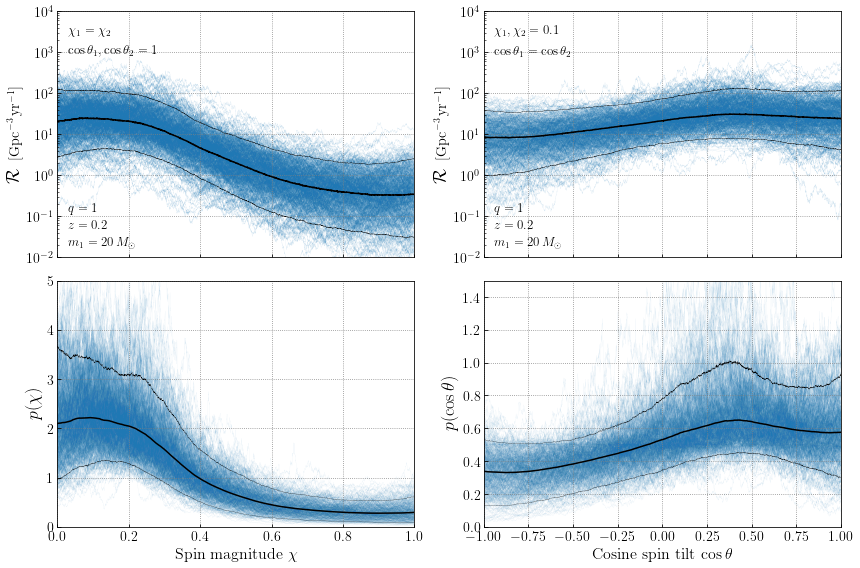

In [99]:
fig = plt.figure(figsize=(12,8))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)

# Convert to dR/dlnm*dq at m1=20 and q=1
p_q1 = (1.+bq)/(1.-(2./20.)**(1.+bq))
dR_dchi_cost1 = R_ref[:,np.newaxis]*f_cost1[:,np.newaxis]**2*f_chis**2*p_q1[:,np.newaxis]*20.
      
for i in np.random.choice(range(dR_dchi_cost1.shape[0]),size=500,replace=False):                 
    ax.plot(chis,dR_dchi_cost1[i,:],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(chis,np.median(dR_dchi_cost1,axis=0),color='black')
ax.plot(chis,np.quantile(dR_dchi_cost1,0.05,axis=0),color='black',lw=0.3)
ax.plot(chis,np.quantile(dR_dchi_cost1,0.95,axis=0),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.92,r'$\chi_1 = \chi_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1,\cos\theta_2 = 1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

dR_dcost_a01 = R_ref[:,np.newaxis]*f_a01[:,np.newaxis]**2*f_costs**2*p_q1[:,np.newaxis]*20.
      
for i in np.random.choice(range(dR_dcost_a01.shape[0]),size=500,replace=False):                 
    ax.plot(costs,dR_dcost_a01[i,:],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(costs,np.median(dR_dcost_a01,axis=0),color='black')
ax.plot(costs,np.quantile(dR_dcost_a01,0.05,axis=0),color='black',lw=0.3)
ax.plot(costs,np.quantile(dR_dcost_a01,0.95,axis=0),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

ax.text(0.03,0.92,r'$\chi_1,\chi_2=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1=\cos\theta_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

p_chi = f_chis/np.trapz(f_chis,chis)[:,np.newaxis]

for i in np.random.choice(range(p_chi.shape[0]),size=500,replace=False):                 
    ax.plot(chis,p_chi[i,:],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(chis,np.mean(p_chi,axis=0),color='black')
ax.plot(chis,np.quantile(p_chi,0.05,axis=0),color='black',lw=0.2)
ax.plot(chis,np.quantile(p_chi,0.95,axis=0),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,5)
#ax.set_yscale('log')

ax.set_xlabel('Spin magnitude $\chi$',fontsize=16)
ax.set_ylabel(r'$p(\chi)$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

p_cost = f_costs/np.trapz(f_costs,costs)[:,np.newaxis]
      
for i in np.random.choice(range(p_cost.shape[0]),size=500,replace=False):                 
    ax.plot(costs,p_cost[i,:],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(costs,np.mean(p_cost,axis=0),color='black')
ax.plot(costs,np.quantile(p_cost,0.05,axis=0),color='black',lw=0.2)
ax.plot(costs,np.quantile(p_cost,0.95,axis=0),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)
#ax.set_yticklabels([])

ax.set_xlabel('Cosine spin tilt $\cos \\theta$',fontsize=16)
ax.set_ylabel(r'$p(\cos\theta)$',fontsize=18)

plt.tight_layout()
plt.savefig('chi_cost.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [11]:
ind_a00 = 0
ind_a02 = np.argmin(np.abs(chis-0.1))
ind_a06 = np.argmin(np.abs(chis-0.6))
ind_a08 = np.argmin(np.abs(chis-0.8))

R_a00_to_a02 = np.trapz(dR_dchi_cost1[:,ind_a00:ind_a02],chis[ind_a00:ind_a02],axis=1)/\
    np.trapz(np.ones(chis[ind_a00:ind_a02].size),chis[ind_a00:ind_a02])
R_a06_to_a08 = np.trapz(dR_dchi_cost1[:,ind_a06:ind_a08],chis[ind_a06:ind_a08],axis=1)/\
    np.trapz(np.ones(chis[ind_a06:ind_a08].size),chis[ind_a06:ind_a08])

rate_ratio = R_a06_to_a08/R_a00_to_a02
rate_ratio[rate_ratio>1].size/rate_ratio.size

0.0

In [20]:
R_one_or_both_neg = np.zeros(alpha.size)
R_tot = np.zeros(alpha.size)
p_neg = np.zeros(alpha.size)
for i in range(alpha.size):
    
    # Define compute distributions for each posterior sample
    m1_grid = np.linspace(2,100.,500)
    f_m1 = massModel(m1_grid,
                     alpha[i],mu_m1[i],sig_m1[i],10.**log_f_peak[i],mMax[i],mMin[i],
                     10.**log_dmMax[i],10.**log_dmMin[i])
    f_m1_norm = massModel(20.,
                     alpha[i],mu_m1[i],sig_m1[i],10.**log_f_peak[i],mMax[i],mMin[i],
                     10.**log_dmMax[i],10.**log_dmMin[i])
    
    # Integrate over masses, in order to obtain integrated rate of negative spin mergers
    int_m1 = np.trapz(f_m1/f_m1_norm,m1_grid)
    
    # Similarly integrate over spin magnitudes and spin tilts
    int_chi = np.trapz(f_chis[i],chis)
    int_cost = np.trapz(f_costs[i],costs)
    
    # Find fraction of events with one or both spins negative
    # We are using the fact that spins are IID, so that e.g. the fraction of events
    # with two negative spins is the *square* of the fraction of individual spins that are negative
    positive_costheta = costs>0    
    negative_costheta = costs<0
    int_both_neg = np.trapz(f_costs[i,negative_costheta],costs[negative_costheta])**2
    int_one_neg = 2.*np.trapz(f_costs[i,negative_costheta],costs[negative_costheta])*np.trapz(f_costs[i,positive_costheta],costs[positive_costheta])
    int_one_or_both_neg = int_both_neg+int_one_neg
    
    # Compute rate of such events
    # Note again that spin magnitudes are IID, so the magnitude integral factor is squared
    R_one_or_both_neg[i] = R_ref[i]*int_m1*int_chi**2*int_one_or_both_neg
    R_tot[i] = R_ref[i]*int_m1*int_chi**2*int_cost**2
    
    # Probability that individual spins are negative
    p_neg[i] = np.trapz(f_costs[i,negative_costheta],costs[negative_costheta])/int_cost
    
print(np.median(R_one_or_both_neg),
      np.quantile(R_one_or_both_neg,0.95)-np.quantile(R_one_or_both_neg,0.5),
      np.quantile(R_one_or_both_neg,0.5)-np.quantile(R_one_or_both_neg,0.05))

print(np.median(p_neg),
      np.quantile(p_neg,0.95)-np.quantile(p_neg,0.5),
      np.quantile(p_neg,0.5)-np.quantile(p_neg,0.05))

print(1-p_neg[p_neg>0.5].size/p_neg.size)

16.780512994659738 10.23418070452739 6.534649333234308
0.4018754037828543 0.09923766876616008 0.13122274979137089
0.9437777777777778


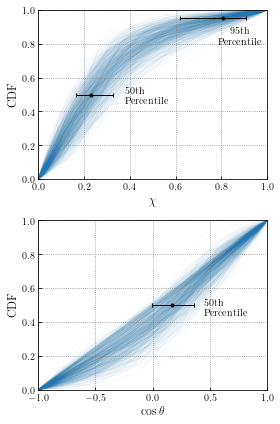

In [137]:
fig = plt.figure(figsize=(4,6))

nDraws = 750
chi_50 = np.zeros(nDraws)
chi_95 = np.zeros(nDraws)

ax = fig.add_subplot(211)
ax.set_rasterization_zorder(1)
for i,j in enumerate(np.random.choice(range(alpha.size),size=nDraws,replace=False)):   
    
    cdf = np.cumsum(p_chi[j,:]*np.diff(np.concatenate([[0],chis])))
    ax.plot(chis,cdf,color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
    chi_50[i] = np.interp(0.5,cdf,chis)
    chi_95[i] = np.interp(0.95,cdf,chis)
    
ax.errorbar([np.median(chi_50),np.median(chi_95)],
            [0.5,0.95],
            xerr=[[np.median(chi_50)-np.quantile(chi_50,0.05),np.median(chi_95)-np.quantile(chi_95,0.05)],
                  [np.quantile(chi_50,0.95)-np.median(chi_50),np.quantile(chi_95,0.95)-np.median(chi_95)]],
            color='black',
            capsize=2,
            elinewidth=1,
            marker='.',
            linestyle="none")

ax.annotate('50th \n Percentile',xy=(0.38,0.45),fontsize=10,ha='left')
ax.annotate('95th \n Percentile',xy=(0.88,0.8),fontsize=10,ha='center')
ax.set_xlabel(r'$\chi$')
ax.set_ylabel(r'CDF')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

cost_50 = np.zeros(nDraws)
cost_95 = np.zeros(nDraws)

ax = fig.add_subplot(212)
ax.set_rasterization_zorder(1)
for i,j in enumerate(np.random.choice(range(alpha.size),size=nDraws,replace=False)):   
    
    cdf = np.cumsum(p_cost[j,:]*np.diff(np.concatenate([[-1],costs])))
    ax.plot(costs,cdf,color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
    cost_50[i] = np.interp(0.5,cdf,costs)
    cost_95[i] = np.interp(0.95,cdf,costs)
    
ax.errorbar(np.median(cost_50),
            0.5,
            xerr=[[np.median(cost_50)-np.quantile(cost_50,0.05)],
                  [np.quantile(cost_50,0.95)-np.median(cost_50)]],
            color='black',
            capsize=2,
            elinewidth=1,
            marker='.',
            linestyle="none")

ax.annotate('50th \n Percentile',xy=(0.45,0.44),fontsize=10,ha='left')
ax.set_xlabel(r'$\cos\theta$')
ax.set_ylabel(r'CDF')
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('spin_cdfs.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [142]:
print(np.median(chi_50),np.quantile(chi_50,0.95)-np.median(chi_50),np.median(chi_50)-np.quantile(chi_50,0.05))
print(np.median(chi_95),np.quantile(chi_95,0.95)-np.median(chi_95),np.median(chi_95)-np.quantile(chi_95,0.05))
print(np.median(cost_50),np.quantile(cost_50,0.95)-np.median(cost_50),np.median(cost_50)-np.quantile(cost_50,0.05))

print(cost_50[cost_50>0].size/cost_50.size)

0.23216871361609176 0.09376065698423236 0.06531660205277956
0.8060142737593547 0.10336226200857768 0.18668496762189402
0.16869654061983927 0.18799984191472927 0.1720137886644834
0.9373333333333334


In [185]:
ind_u_n02 = np.argmin(np.abs(chis-(-0.2)))
ind_u_005 = np.argmin(np.abs(chis-0.05))
ind_u_075 = np.argmin(np.abs(chis-0.75))
ind_u_10 = -1

f_u_n02_to_u_005 = np.trapz(f_costs[:,ind_u_n02:ind_u_005],costs[ind_u_n02:ind_u_005],axis=1)/\
    np.trapz(np.ones(costs[ind_u_n02:ind_u_005].size),costs[ind_u_n02:ind_u_005])
f_u_005_to_u_075 = np.trapz(f_costs[:,ind_u_005:ind_u_075],costs[ind_u_005:ind_u_075],axis=1)/\
    np.trapz(np.ones(costs[ind_u_005:ind_u_075].size),costs[ind_u_005:ind_u_075])
f_u_075_to_u_10 = np.trapz(f_costs[:,ind_u_075:ind_u_10],costs[ind_u_075:ind_u_10],axis=1)/\
    np.trapz(np.ones(costs[ind_u_075:ind_u_10].size),costs[ind_u_075:ind_u_10])

"""f_u_n02_to_u_005 = np.trapz(dR_dcost_a01[:,ind_u_n02:ind_u_005],costs[ind_u_n02:ind_u_005],axis=1)/\
    np.trapz(np.ones(costs[ind_u_n02:ind_u_005].size),costs[ind_u_n02:ind_u_005])
f_u_005_to_u_075 = np.trapz(dR_dcost_a01[:,ind_u_005:ind_u_075],costs[ind_u_005:ind_u_075],axis=1)/\
    np.trapz(np.ones(costs[ind_u_005:ind_u_075].size),costs[ind_u_005:ind_u_075])
f_u_075_to_u_10 = np.trapz(dR_dcost_a01[:,ind_u_075:ind_u_10],costs[ind_u_075:ind_u_10],axis=1)/\
    np.trapz(np.ones(costs[ind_u_075:ind_u_10].size),costs[ind_u_075:ind_u_10])"""

f_ratio_high = f_u_005_to_u_075/f_u_075_to_u_10
f_ratio_low = f_u_005_to_u_075/f_u_n02_to_u_005
print(f_ratio_high[(f_ratio_high>1)*(f_ratio_low>1)].size/f_ratio_high.size)
f_ratio_low[f_ratio_low>1].size/f_ratio_low.size

0.26311111111111113


0.9146666666666666

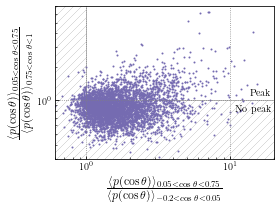

In [184]:
fig = plt.figure(figsize=(4,3))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

ax.scatter(f_ratio_low,f_ratio_high,s=1,color='#756bb1',zorder=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.6,20)
ax.set_ylim(0.3,7)

ax.set_xlabel(r'$\frac{\langle p(\cos\theta)\rangle_{0.05<\cos\theta<0.75}}{\langle p(\cos\theta)\rangle_{-0.2<\cos\theta <0.05}}$',
             fontsize=17)
ax.set_ylabel(r'$\frac{\langle p(\cos\theta)\rangle_{0.05<\cos\theta<0.75}}{\langle p(\cos\theta)\rangle_{0.75<\cos\theta<1}}$',
             fontsize=17)

ax.text(0.99, 0.4, 'Peak',
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.text(0.99, 0.3, 'No peak',
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.fill_between([0.4,20],[1,1],hatch='///',facecolor='None',zorder=-1,linewidth=0)
ax.fill_betweenx([1,7],[1,1],hatch='///',facecolor='None',zorder=-1,linewidth=0)
ax.plot([1,1,20],[7,1,1],color='grey',zorder=-1,lw=0.5)

plt.tight_layout()
plt.savefig('cos_theta_features.pdf',dpi=200,bbox_inches='tight')

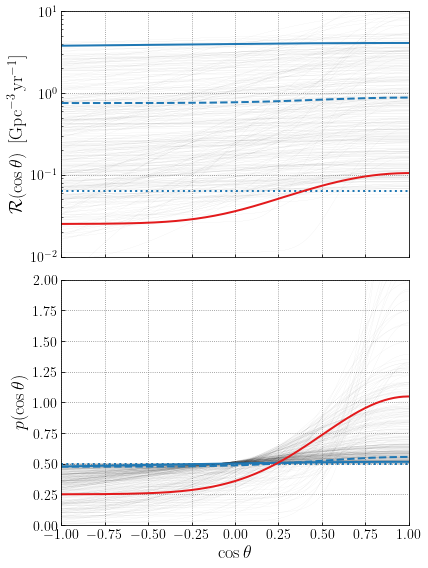

In [197]:
def tilt_prob(us,frac_aligned,sig_cost):
    
    p_aligned = np.exp(-(us-1.)**2/(2.*sig_cost**2))*np.sqrt(2./(np.pi*sig_cost**2))
    p_aligned_norm = erf(0.) - erf(-2./np.sqrt(2.*sig_cost**2))
    p_aligned /= p_aligned_norm
    
    p_iso = 0.5*np.ones(us.size)
    
    p_full = frac_aligned*p_aligned + (1.-frac_aligned)*p_iso
    return p_full

fig = plt.figure(figsize=(6,8))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_rasterization_zorder(1)
ax2.set_rasterization_zorder(1)

us = np.linspace(-1,1,300)

nTrials = 300
ps_full = np.zeros((nTrials,us.size))

for i in range(nTrials):
    
    logR = 2.*np.random.random() - 1.
    frac_aligned = np.random.random()
    sig_cost = (2.-0.2)*np.random.random() + 0.2
    
    p_full = tilt_prob(us,frac_aligned,sig_cost)
    ps_full[i,:] = p_full
    
    ax1.plot(us,10.**logR*p_full,color='black',alpha=0.2,lw=0.1)
    ax2.plot(us,p_full,color='black',alpha=0.2,lw=0.1)
    
#### Explicit 1
logR = 0.9
frac_aligned = 0.1
sig_cost = 1.5
p_full = tilt_prob(us,frac_aligned,sig_cost)
ax1.plot(us,10.**logR*p_full,color='#1f78b4',lw=2)
ax2.plot(us,p_full,color='#1f78b4',lw=2)

#### Explicit 2
logR = 0.2
frac_aligned = 0.05
sig_cost = 0.5
p_full = tilt_prob(us,frac_aligned,sig_cost)
ax1.plot(us,10.**logR*p_full,color='#1f78b4',lw=2,ls='--')
ax2.plot(us,p_full,color='#1f78b4',lw=2,ls='--')

#### Explicit 3
logR = -0.9
frac_aligned = 0.0
sig_cost = 0.5
p_full = tilt_prob(us,frac_aligned,sig_cost)
ax1.plot(us,10.**logR*p_full,color='#1f78b4',lw=2,ls=':')
ax2.plot(us,p_full,color='#1f78b4',lw=2,ls=':')

#### Explicit 4
logR = -1
frac_aligned = 0.5
sig_cost = 0.5
p_full = tilt_prob(us,frac_aligned,sig_cost)
ax1.plot(us,10.**logR*p_full,color='#e31a1c',lw=2)
ax2.plot(us,p_full,color='#e31a1c',lw=2)
    
ax.fill_between(us,
                np.quantile(ps_full,0.05,axis=0),
                np.quantile(ps_full,0.95,axis=0))

ax1.set_xlim(-1,1)
ax1.set_ylim(1e-2,1e1)
ax1.set_yscale('log')
ax1.set_xticklabels([])
ax1.set_ylabel(r"$\mathcal{R}(\cos\theta)$ \,[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]")

ax2.set_xlim(-1,1)
ax2.set_ylim(0,2)
ax2.set_ylabel(r"$p(\cos\theta)$")
ax2.set_xlabel(r"$\cos\theta$")

plt.tight_layout()
plt.savefig('cost_demo.pdf',bbox_inches='tight',dpi=200)

0.8966666666666666


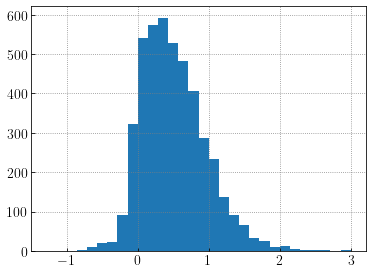

In [8]:
ind_cost_n10 = 0
ind_cost_n09 = np.argmin(np.abs(costs+0.9))
ind_cost_09 = np.argmin(np.abs(costs-0.9))
ind_cost_10 = np.argmin(np.abs(costs-1.0))

R_cost_n10_to_n09 = np.trapz(dR_dcost_a01[:,ind_cost_n10:ind_cost_n09],costs[ind_cost_n10:ind_cost_n09],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_n10:ind_cost_n09].size),costs[ind_cost_n10:ind_cost_n09])
R_cost_09_to_10 = np.trapz(dR_dcost_a01[:,ind_cost_09:ind_cost_10],costs[ind_cost_09:ind_cost_10],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_09:ind_cost_10].size),costs[ind_cost_09:ind_cost_10])

rate_ratio = R_cost_09_to_10/R_cost_n10_to_n09

print(rate_ratio[rate_ratio>1].size/rate_ratio.size)

plt.hist(np.log10(rate_ratio),bins=30)
plt.show()

0.5275555555555556
0.6933333333333334
0.37533333333333335


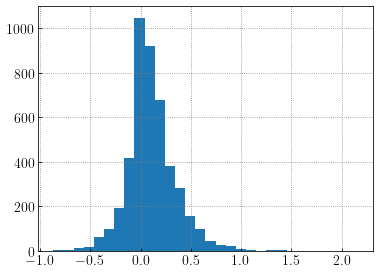

In [43]:
ind_cost_05 = np.argmin(np.abs(costs-0.05))
ind_cost_15 = np.argmin(np.abs(costs-0.15))
ind_cost_25 = np.argmin(np.abs(costs-0.25))
ind_cost_50 = np.argmin(np.abs(costs-0.5))
ind_cost_60 = np.argmin(np.abs(costs-0.6))
ind_cost_70 = np.argmin(np.abs(costs-0.7))

R_cost_05_to_15 = np.trapz(dR_dcost_a01[:,ind_cost_05:ind_cost_15],costs[ind_cost_05:ind_cost_15],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_05:ind_cost_15].size),costs[ind_cost_05:ind_cost_15])
R_cost_25_to_50 = np.trapz(dR_dcost_a01[:,ind_cost_25:ind_cost_50],costs[ind_cost_25:ind_cost_50],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_25:ind_cost_50].size),costs[ind_cost_25:ind_cost_50])
R_cost_60_to_70 = np.trapz(dR_dcost_a01[:,ind_cost_60:ind_cost_70],costs[ind_cost_60:ind_cost_70],axis=1)/\
    np.trapz(np.ones(costs[ind_cost_60:ind_cost_70].size),costs[ind_cost_60:ind_cost_70])

rate_ratio_low = R_cost_25_to_50/R_cost_05_to_15
rate_ratio_high = R_cost_25_to_50/R_cost_60_to_70

print(rate_ratio_low[(rate_ratio_high>1)].size/rate_ratio_low.size)
print(rate_ratio_low[(rate_ratio_low>1)].size/rate_ratio_low.size)
print(rate_ratio_low[(rate_ratio_low>1)*(rate_ratio_high>1)].size/rate_ratio_low.size)

plt.hist(np.log10(rate_ratio),bins=30)
plt.show()

0.9402222222222222
0.9471111111111111


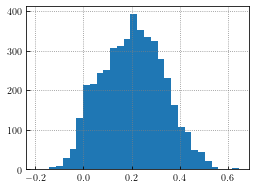

0.9388888888888889


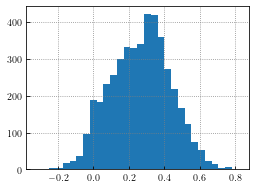

In [22]:
ind_cost_00 = np.argmin(np.abs(costs-0.0))
R_neg = np.trapz(dR_dcost_a01[:,:ind_cost_00],costs[:ind_cost_00],axis=1)
R_pos = np.trapz(dR_dcost_a01[:,ind_cost_00:],costs[ind_cost_00:],axis=1)
print(R_pos[R_pos>R_neg].size/R_pos.size)

mean_cost = np.trapz(costs[np.newaxis,:]*dR_dcost_a01[:,:],
                     costs,axis=1)/\
    np.trapz(dR_dcost_a01,costs,axis=1)

print(mean_cost[mean_cost>0].size/mean_cost.size)
plt.hist(mean_cost,bins=30)
plt.show()

median_costs = np.zeros(dR_dcost_a01.shape[0])
for i in range(dR_dcost_a01.shape[0]):
    
    cdf_cost = np.cumsum(dR_dcost_a01[i,:-1]*np.diff(costs))
    cdf_cost /= cdf_cost[-1]
    
    median_costs[i] = np.interp(0.5,cdf_cost,costs[:-1])
    
print(median_costs[median_costs>0].size/median_costs.size)
plt.hist(median_costs,bins=30)
plt.show()

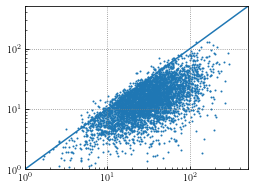

In [32]:
fig,ax = plt.subplots(figsize=(4,3))
ax.scatter(R_pos,R_neg,s=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,500)
ax.set_ylim(1,500)
ax.plot([1,500],[1,500])

In [118]:
def truncatedNormal(x,mu,sig):
    
    norm = 0.5*(erf((1.-mu)/np.sqrt(2.*sig**2)) - erf((0.-mu)/np.sqrt(2.*sig**2)))
    return np.exp(-(x-mu)**2/(2.*sig**2))/np.sqrt(2.*np.pi*sig**2)/norm

def lorentzian(x,mu,gamma):
    
    norm = (np.arctan((1.-mu)/gamma) - np.arctan((0.-mu)/gamma))/np.pi
    return (1./(np.pi*gamma))*1./(1.+((x-mu)/gamma)**2)/norm

def cost_mixture(u,f_iso,mu,sig):
    
    p_iso = 0.5*np.ones_like(u)
    p_gaussian_norm = 0.5*(erf((1.-mu)/np.sqrt(2.*sig**2)) - erf((-1.-mu)/np.sqrt(2.*sig**2)))
    p_gaussian = np.exp(-(u-mu)**2/(2.*sig**2))/np.sqrt(2.*np.pi*sig**2)/p_gaussian_norm
    
    return  p_iso*f_iso + p_gaussian*(1.-f_iso)

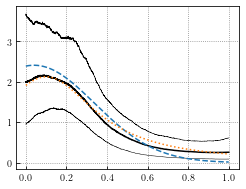

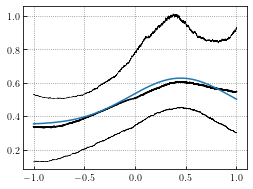

In [119]:
fig,ax = plt.subplots()
ax.plot(chis,np.quantile(p_chi,0.05,axis=0),color='black',lw=0.5)
ax.plot(chis,np.quantile(p_chi,0.95,axis=0),color='black',lw=0.5)
ax.plot(chis,np.quantile(p_chi,0.5,axis=0),color='black')

mu = 0.04
sig = 0.3
test = truncatedNormal(chis,mu,sig)
ax.plot(chis,test,ls='--')

x0 = 0.1
gamma = 0.3
test = lorentzian(chis,x0,gamma)
ax.plot(chis,test,ls=':')

plt.show()

fig,ax = plt.subplots()
ax.plot(costs,np.quantile(p_cost,0.05,axis=0),color='black',lw=0.5)
ax.plot(costs,np.quantile(p_cost,0.95,axis=0),color='black',lw=0.5)
ax.plot(costs,np.quantile(p_cost,0.5,axis=0),color='black')

f_iso = 0.7
u_mu = 0.45
u_sig = 0.5
test = cost_mixture(costs,f_iso,u_mu,u_sig)
ax.plot(costs,test)

plt.show()

In [120]:
from scipy.optimize import minimize

p_chi_target = np.median(p_chi,axis=0)
p_cost_target = np.median(p_cost,axis=0)

def ls_gaussian(params):
    
    mu,sig = params
    p_chi_model = truncatedNormal(chis,mu,sig)
    
    return np.trapz((p_chi_model-p_chi_target)**2,chis)

def ls_lorentzian(params):
    
    mu,gamma = params
    p_chi_model = lorentzian(chis,mu,gamma)
    
    return np.trapz((p_chi_model-p_chi_target)**2,chis)

def ls_costs(params):
    
    f_iso,u_mu,u_sig = params
    p_cost_model = cost_mixture(costs,f_iso,u_mu,u_sig)
    
    return np.trapz((p_cost_model-p_cost_target)**2,costs)

In [121]:
initial_params_gaussian = (mu,sig)
gaussian_soln = minimize(ls_gaussian,
                         initial_params_gaussian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

initial_params_lorentzian = (x0,gamma)
lorentzian_soln = minimize(ls_lorentzian,
                         initial_params_lorentzian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

initial_params_cost = (f_iso,u_mu,u_sig)
cost_soln = minimize(ls_costs,
                         initial_params_cost,
                         method='Nelder-Mead',
                         options={'maxiter':1e5})

print(gaussian_soln.success,gaussian_soln.x)
print(lorentzian_soln.success,lorentzian_soln.x)
print(cost_soln.success,cost_soln.x)

True [0.         0.35813207]
True [0.10432722 0.27297568]
True [0.64248348 0.5220555  0.63794702]


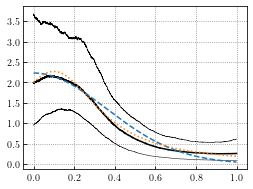

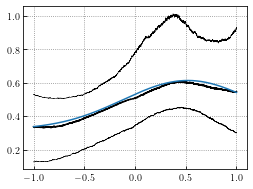

In [122]:
fig,ax = plt.subplots()
ax.plot(chis,np.quantile(p_chi,0.05,axis=0),color='black',lw=0.5)
ax.plot(chis,np.quantile(p_chi,0.95,axis=0),color='black',lw=0.5)
ax.plot(chis,np.quantile(p_chi,0.5,axis=0),color='black')

mu = 0.0
sig = 0.36
test = truncatedNormal(chis,mu,sig)
ax.plot(chis,test,ls='--')

x0 = 0.1
gamma = 0.27
test = lorentzian(chis,x0,gamma)
ax.plot(chis,test,ls=':')

plt.show()

fig,ax = plt.subplots()
ax.plot(costs,np.quantile(p_cost,0.05,axis=0),color='black',lw=0.5)
ax.plot(costs,np.quantile(p_cost,0.95,axis=0),color='black',lw=0.5)
ax.plot(costs,np.quantile(p_cost,0.5,axis=0),color='black')

f_iso = 0.64
u_mu = 0.52
u_sig = 0.64
test = cost_mixture(costs,f_iso,u_mu,u_sig)
ax.plot(costs,test)

plt.show()

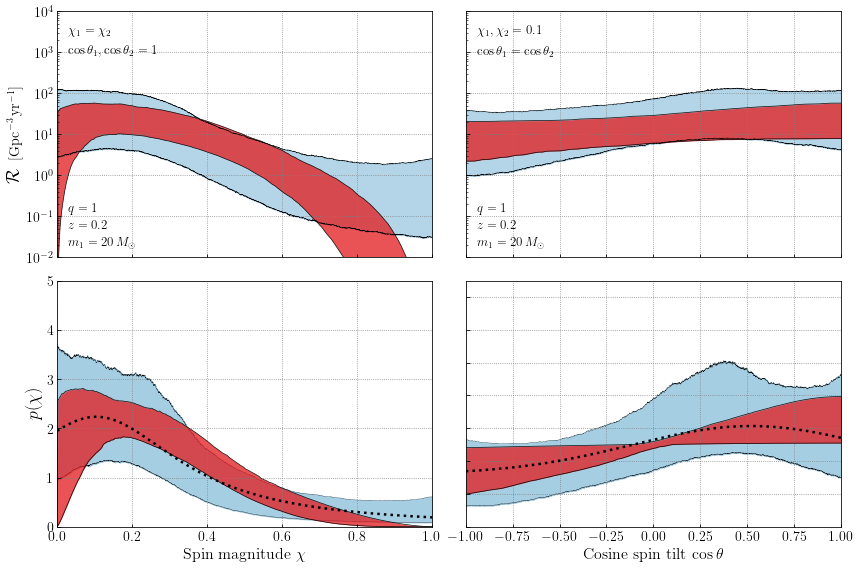

In [126]:
fig = plt.figure(figsize=(12,8))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)
    
#ax.plot(chis,np.median(dR_dchi_cost1,axis=0),color='black')
ax.plot(chis,np.quantile(dR_dchi_cost1,0.05,axis=0),color='black',lw=0.5)
ax.plot(chis,np.quantile(dR_dchi_cost1,0.95,axis=0),color='black',lw=0.5)
ax.fill_between(chis,
                np.quantile(dR_dchi_cost1,0.05,axis=0),
                np.quantile(dR_dchi_cost1,0.95,axis=0),
                color='#a6cee3',alpha=0.85,zorder=-1)

#ax.plot(lvk_chi_grid,np.mean(lvk_R_chi,axis=0),color='black',zorder=-2)
ax.plot(lvk_chi_grid,np.quantile(lvk_R_chi,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chi_grid,np.quantile(lvk_R_chi,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_R_chi,0.05,axis=0),
                np.quantile(lvk_R_chi,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.92,r'$\chi_1 = \chi_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1,\cos\theta_2 = 1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

#ax.plot(costs,np.median(dR_dcost_a01,axis=0),color='black')
ax.plot(costs,np.quantile(dR_dcost_a01,0.05,axis=0),color='black',lw=0.5)
ax.plot(costs,np.quantile(dR_dcost_a01,0.95,axis=0),color='black',lw=0.5)
ax.fill_between(costs,
                np.quantile(dR_dcost_a01,0.05,axis=0),
                np.quantile(dR_dcost_a01,0.95,axis=0),
                color='#a6cee3',alpha=0.85,zorder=-1)

#ax.plot(lvk_cost_grid,np.mean(lvk_R_cost,axis=0),color='black',zorder=-2)
ax.plot(lvk_cost_grid,np.quantile(lvk_R_cost,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_cost_grid,np.quantile(lvk_R_cost,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_R_cost,0.05,axis=0),
                np.quantile(lvk_R_cost,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(0.03,0.92,r'$\chi_1,\chi_2=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1=\cos\theta_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

#ax.plot(chis,np.median(p_chi,axis=0),color='black')
ax.plot(chis,np.quantile(p_chi,0.05,axis=0),color='black',lw=0.3,zorder=0)
ax.plot(chis,np.quantile(p_chi,0.95,axis=0),color='black',lw=0.2,zorder=0)
ax.fill_between(chis,
                np.quantile(p_chi,0.05,axis=0),
                np.quantile(p_chi,0.95,axis=0),
                color='#a6cee3',alpha=1,zorder=-1)

#ax.plot(lvk_chi_grid,np.mean(lvk_p_chis,axis=0),color='black',zorder=-2)
ax.plot(lvk_chi_grid,np.quantile(lvk_p_chis,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_chi_grid,np.quantile(lvk_p_chis,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_p_chis,0.05,axis=0),
                np.quantile(lvk_p_chis,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.plot(chis,lorentzian(chis,*lorentzian_soln.x),color='black',ls=':',lw=2.5,label='Eq. 16')

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,5)

ax.set_xlabel('Spin magnitude $\chi$',fontsize=16)
ax.set_ylabel(r'$p(\chi)$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

#ax.plot(costs,np.median(p_cost,axis=0),color='black')
ax.plot(costs,np.quantile(p_cost,0.05,axis=0),color='black',lw=0.3,zorder=0)
ax.plot(costs,np.quantile(p_cost,0.95,axis=0),color='black',lw=0.2,zorder=0)
ax.fill_between(costs,
                np.quantile(p_cost,0.05,axis=0),
                np.quantile(p_cost,0.95,axis=0),
                color='#a6cee3',alpha=1,zorder=-1)

#ax.plot(lvk_cost_grid,np.mean(lvk_p_costs,axis=0),color='black',zorder=-2)
ax.plot(lvk_cost_grid,np.quantile(lvk_p_costs,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_cost_grid,np.quantile(lvk_p_costs,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_p_costs,0.05,axis=0),
                np.quantile(lvk_p_costs,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.plot(costs,cost_mixture(costs,*cost_soln.x),color='black',ls=':',lw=2.5,label='Eq. 16')

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)
ax.set_yticklabels([])

ax.set_xlabel('Cosine spin tilt $\cos \\theta$',fontsize=16)

plt.tight_layout()
plt.savefig('chi_cost_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()